In [1]:
import os
import glob
import rosbag
import pandas as pd
import numpy as np
import cv2
import time 

from os import path
import matplotlib.pyplot as plt
from utils.visualisation import *

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [20]:
FILE = '/home/francesco/Desktop/carino/vaevictis/data/dataset/bars1/1548532078.2135954.csv'

In [21]:
df = pd.read_csv(FILE)
# world, X, Y = create_trace_world(df, res)

<IPython.core.display.Javascript object>


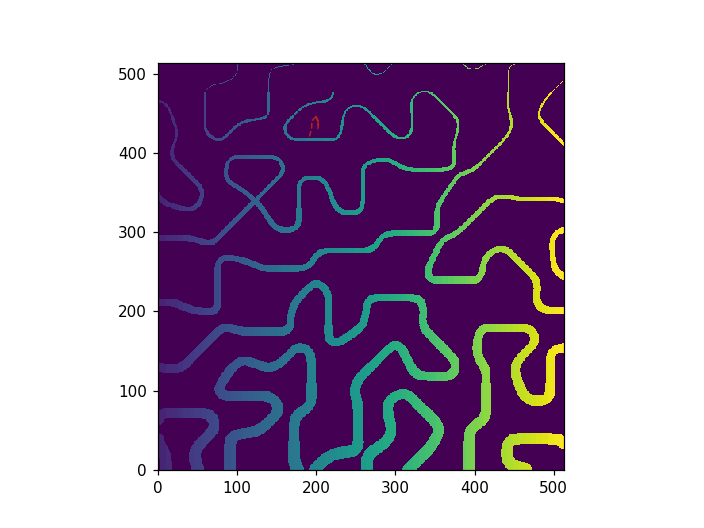

(513, 513)


In [24]:
show_trace(df, 'bars1')

In [ ]:
X = np.arange(-50, 50, 1)
Y = np.arange(-50, 50, 1)
create3dtrace(world, X, Y, 'bars1')